# Magnificent 7 Backtesting
by Willy Seah

In this analysis, I will attempt at creating a backtesting system to evaluate a 
group of stocks known as the "Magnificent 7": Microsoft (MSFT), Apple (AAPL), Nvidia (NVDA),
Amazon (AMZN), Google (GOOG), Meta (META), and Tesla (TSLA) in the U.S. stock market. 

# Section 1: Downloading & processing of data
Used Yahoo Finance for source of data and have set auto_adjust query parameter to be True to account for adjusted open close prices. 

There are 7 tickers and they will be stored in a dictionary `stock_data` where the key is the ticker and value is the dataframe from Yahoo.

Have decided to drop the Volume, High and Low columns as they are not necessary for my backtesting. 

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None) 

tickers = ['MSFT', 'AAPL', 'NVDA','AMZN','GOOG','META','TSLA']
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, start = '1981-01-01', end = '2023-12-31', auto_adjust=True)
    stock_data[ticker] = stock_data[ticker].drop(['Volume', 'High', 'Low'], axis=1) # Do not need this

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Section 1b: Cleaning of Dataset
We check if there are any NaN/Null data for the 7 datasets we downloaded. 
For this case, I have ran it and there is no missing datas.

If there is we could either choose to:
1. Drop the row
2. Forward fill them using `.fillna(method='ffill')`

But since that is not the case here, I have skipped/commented it out. 

For dirty datasets it is important that we do the necesssary cleaning/pre-processing to ensure the accuracy of our backtesting result. 


In [5]:
# for ticker, df in stock_data.items():
#     for index, row in df.iterrows():
#         for column in df.columns:
#             if pd.isnull(row[column]):
#                 print(f"Missing value found in {ticker} at index {index} and column {column}")

# Section 2: Implementing an Indicator
The indicator used for my backtesting is Relative Strength Index, a momentum indicator that measures the speed and change of price movement of a security over 14 days.

**It is used to identify overbought and oversold conditions in the market.**

Given we have the 'Close' prices from the previous step, we can use `calculate_rsi` function to create a 'RSI' column and add it to the 7 dataframe we have, each for 1 ticker.

In [46]:
import ta
import pandas as pd

def calculate_rsi(df, window=14):
    delta = df.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ticker, data in stock_data.items():
    data['RSI'] = calculate_rsi(data['Close'])

# Section 3: Generating signals using our indicator

We are using these formuals to determine whether to buy or sell that stock
- Buy Signal: RSI < 25 (indicates an oversold stock)
- Sell Signal: RSI > 75 (indicates an overbought stock)

Append 2 new columns to each of the dataframe indicating when to Buy and Sell. They are mutually exclusive in the sense where it will be **Buy Or Sell Or Do Nothing**. There will not be an instance of both Buy And Sell

In [49]:
# Define buy and sell signals

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

for ticker, data in stock_data.items():
    data['Buy Signal'] = np.where(data['RSI'] < 25, 1, 0)
    data['Sell Signal'] = np.where(data['RSI'] > 75, 1, 0)


# Section 4: Backtesting

From 1981-01-01 till 2023-12-31, we iterate each day and check if there is a Buy or Sell Signal for each of our 7 tickers. 

Use a dictionary/map called `portfolio` to indicate which ticker and shares_held. 

Here are the requirements:

1. Initial Capital: USD 1,000,000
2. Commission per trade: 0.10%
3. Slippage per trade: 0.02%
4. Minimum transaction: 10 shares per trade
5. Equal weightage among stocks that I need to Buy or Sell

For simplicity, I have set the order size for every trade to be **X (to be discussed more below)**, this is to ensure fairness throughout each ticker. 

Before buying we check that we have enough `initial_capital` before buying, if there is insufficient then we are unable to buy and hence 'lose' that opportunity to buy that stock. 

- When there is a Buy Signal:

    I purchase X of that stock at its Close price

    Add that to my `portfolio`
  
    Reduce the `initial_capital` 

- When there is a Sell Signal:

    I sell X of that stock at its Close price
  
    Deduct that from my `portfolio`

    Add it to `initial_capital`


At the end of every day, I calculate my `total_portfolio_value` which is initial_capital + the current closing price of all my portfolio holdings and save it into a `portfolio_value_df` 

At the end of everyday, I also perform portfolio rebalancing should a single stock exceed 30% of my `total_portfolio_value` (excluding initial_capital). This is done by calculating how much excess share needed to be sold to bring it under 30%, and this selling price is added back to my initial_capital



# Further explanation of some points:

1. The tricky part is to decide what is X, the number of shares to buy every time there is a Buy Signal. I have tried where X is 100,200,... 2000 , in intervals of 100.
By varying X, we are finding a balance between keeping USD (stale cash) that is not invested and hence have no returns at all vs buying now, and risk not being able to buy later due to insufficient capital. 

2. Although in real life scenario, we could go negative initial_capital where we take on Margin, (by borrowing from the exchange). There is another level of complexity such as 'borrowing_interest_rate', because there is a fee the exchange charges when borrowing from them. Also there is a risk of Margin Call / Auto Liquidation. That is not our prioirity here, therefore, I chose to ensure that we do not go into Margin. 

3. During portfolio rebalancing, I sold the excess share and converted them into cash (in initial_capital) which will then be used for future purchases. 

In [53]:
def backtest_strategy(stock_data, min_shares_per_trade):
    portfolio = {}
    portfolio_values = []
    
    initial_capital = 1000000
    commission_rate = 0.001  # 0.1% commission
    slippage_rate = 0.0002  # 0.02% slippage
    start_date = '1981-01-01'
    end_date = '2023-12-31'
    date_range = pd.bdate_range(start=start_date, end=end_date)


    for date_str in date_range.strftime('%Y-%m-%d'):
        for ticker in ['MSFT', 'AAPL', 'NVDA','AMZN','GOOG','META','TSLA']:
            if ticker in stock_data:
                df = stock_data[ticker]
                if date_str in df.index:
                    close_price = df.loc[date_str]['Close']
    
                    # Buy signal
                    if df.loc[date_str]['Buy Signal'].any() == 1:
                        shares_to_buy = min_shares_per_trade
                        total_cost = shares_to_buy * close_price.values[0] * (1 + commission_rate + slippage_rate)
                        if total_cost <= initial_capital:
                            portfolio[ticker] = portfolio.get(ticker, 0) + shares_to_buy
                            initial_capital -= total_cost
                            #print(f"Buying {shares_to_buy} shares of {ticker} at {total_cost} on {date_str}")
    
                    # Sell signal
                    elif df.loc[date_str]['Sell Signal'].any() == 1 and ticker in portfolio and portfolio[ticker] >= min_shares_per_trade:
                        shares_to_sell = min_shares_per_trade 
                        total_cost = shares_to_sell * close_price.values[0] * (1 - commission_rate - slippage_rate) 
                        initial_capital += total_cost
                        portfolio[ticker] -= shares_to_sell
                        #print(f"Selling {shares_to_sell} shares of {ticker} at {total_cost} on {date_str}")

        if (initial_capital < 0):
            return False, portfolio_values

        # Rebalance portfolio at the end of each day, calculate total_portfolio_value at the end of every day
        total_portfolio_value = 0
        for ticker, shares in portfolio.items():
            df = stock_data[ticker]
            if date_str in df.index:
                close_price = df.loc[date_str]['Close']
                total_portfolio_value += shares * close_price.values[0]
        
        for ticker, shares in portfolio.items():
            df = stock_data[ticker]
            if date_str in df.index:
                close_price = df.loc[date_str]['Close']
                ticker_value = shares * close_price.values[0]
    
                # Calculate the maximum allowed shares for this stock
                max_shares = int(0.3 * total_portfolio_value / close_price.values[0])
                #print(f"max shares is {max_shares} and shares is {shares}")
    
                if shares > max_shares:
                    excess_shares = shares - max_shares
                    initial_capital += excess_shares * close_price.values[0] * (1 - commission_rate - slippage_rate)
                    portfolio[ticker] -= excess_shares
                    #print(f"Rebalancing: Selling {excess_shares} shares of {ticker} on {date_str}")

        # Add into a portfolio dataframe for each day what is my cash left + value in portfolio
        portfolio_values.append(total_portfolio_value + initial_capital)
                
    return True, portfolio_values

min_shares 100 + final_value 1301139.5792109433
min_shares 200 + final_value 1557293.2529918817
min_shares 300 + final_value 1835551.4988856046
min_shares 400 + final_value 1984294.378552737
min_shares 500 + final_value 2200419.847119014
min_shares 600 + final_value 2482414.7249961644
min_shares 700 + final_value 2669083.5778064756
min_shares 800 + final_value 2754467.1100551933
min_shares 900 + final_value 3104885.616934397
min_shares 1000 + final_value 3043343.935562693
min_shares 1100 + final_value 3309251.0447705374
min_shares 1200 + final_value 3692009.4286413137
min_shares 1300 + final_value 3416736.595313581
min_shares 1400 + final_value 4251894.23795328
min_shares 1500 + final_value 3974801.907536555
min_shares 1600 + final_value 3580629.728049697
min_shares 1700 + final_value 5218523.023709699
min_shares 1800 + final_value 4336938.768014129
min_shares 1900 + final_value 5257307.20039621
min_shares 2000 + final_value 4937616.566892726


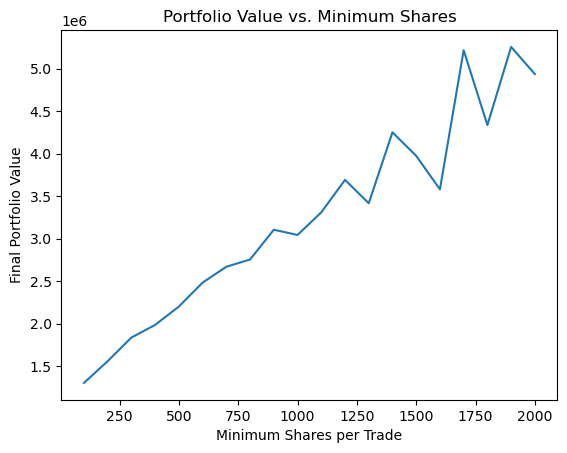

In [14]:
import matplotlib.pyplot as plt

def run_backtest(min_shares):
    success, portfolio_values = backtest_strategy(stock_data, min_shares)
    if success:
        final_portfolio_value = portfolio_values[-1]
        return final_portfolio_value
    else:
        return None

min_shares_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
results = []

for min_shares in min_shares_list:
    final_value = run_backtest(min_shares)
    print(f"min_shares {min_shares} + final_value {final_value}")
    results.append((min_shares, final_value))


# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['Min Shares', 'Final Value'])

# Plot the results
plt.plot(df['Min Shares'], df['Final Value'])
plt.xlabel('Minimum Shares per Trade')
plt.ylabel('Final Portfolio Value')
plt.title('Portfolio Value vs. Minimum Shares')
plt.show()

# Section 4b: Backtesting
We know that the best X, number_of_shares each time to buy, is 1900. 

(A possible enhancement is to try every value from 1 to a larger number, and since fractional shares are allowed as well, this leads to too many possibilities of X being tested). 

Hence I will set number_of_shares to buy to be 1900. 






In [55]:
gotBorrow, portfolio_values, = backtest_strategy(stock_data, 1900)

start_date = '1981-01-01'
end_date = '2023-12-31'
date_range = pd.bdate_range(start=start_date, end=end_date)

portfolio_value_df = pd.DataFrame({'Date': date_range, 'Portfolio Value': portfolio_values})
portfolio_value_df.set_index('Date', inplace=True)

pd.options.display.float_format = '{:.2f}'.format
print(portfolio_value_df.head())



            Portfolio Value
Date                       
1981-01-01       1000000.00
1981-01-02       1000000.00
1981-01-05       1000000.00
1981-01-06       1000000.00
1981-01-07       1000000.00


# Section 5: Clearing Portfolio on last day of trading

At the last day of the trading, I calculate my initial_capital (cash component) + stocks values using 2023-12-31, last day's Closing price, to come up with `final_amount`

This can be obtained from the final row of `portfolio_value_df`  



In [58]:
final_amount = portfolio_value_df.iloc[-1]

print(f"Final amount: {final_amount.values[0]}")

Final amount: 5257307.20039621


# Section 6: Calculating the performance metrics 


In [61]:
total_return = (final_amount - 1000000) / 1000000 
print(f"Total Return: {total_return.item() * 100:.2f} %")

annual_return = (total_return * 100) / 43
print(f"Annual Return: {annual_return.item():.2f} %")

portfolio_value_df['Daily Return'] = portfolio_value_df['Portfolio Value'].pct_change()
annual_volatility = portfolio_value_df['Daily Return'].std() * np.sqrt(252)
print(f"Annual Volatility: {annual_volatility.item():.2f}")

# Calculate maximum drawdown, measure of the peak-to-trough decline
portfolio_value_df['Drawdown'] = portfolio_value_df['Portfolio Value'].cummax() - portfolio_value_df['Portfolio Value']
max_drawdown = portfolio_value_df['Drawdown'].max() / portfolio_value_df['Portfolio Value'].max() * 100
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Calculate Sharpe Ratio
risk_free_rate = 0.02  
sharpe_ratio = (portfolio_value_df['Daily Return'].mean() - risk_free_rate) / annual_volatility
print(f"Sharpe Ratio: {sharpe_ratio.item()}")

# Calculate Sortino Ratio
excess_returns = portfolio_value_df['Daily Return'] - risk_free_rate / 252  # Adjust for daily risk-free rate
downside_deviation = excess_returns[excess_returns < 0].std() * np.sqrt(252)
sortino_ratio = excess_returns.mean() / downside_deviation
print(f"Sortino Ratio: {sortino_ratio}")



Total Return: 425.73 %
Annual Return: 9.90 %
Annual Volatility: 5119.85
Maximum Drawdown: 92.57%
Sharpe Ratio: 0.0008554622781080126
Sortino Ratio: 4.723530009740623


# Section 6b Further Analysis on every Trade 

1. Every Sell is considered 1 trade
2. At the end of 2023-12-31 there are still assets in portfolio and we do not sell them as that is not following our RSI Signal

In [64]:
# Similar function to backtest_strategy but we are only concerned about the trades

def analyze_trades(stock_data, min_shares_per_trade):
    portfolio = {}  # {ticker: (shares_held, average_cost_basis)}
    portfolio_values = []
    
    initial_capital = 1000000
    commission_rate = 0.001  # 0.1% commission
    slippage_rate = 0.0002  # 0.02% slippage
    start_date = '1981-01-01'
    end_date = '2023-12-31'
    date_range = pd.bdate_range(start=start_date, end=end_date)
    total_trades = 0
    total_profit_loss = 0
    num_of_profitable_trade = 0


    for date_str in date_range.strftime('%Y-%m-%d'):
        for ticker in ['MSFT', 'AAPL', 'NVDA','AMZN','GOOG','META','TSLA']:
            if ticker in stock_data:
                df = stock_data[ticker]
                if date_str in df.index:
                    close_price = df.loc[date_str]['Close']
    
                    # Buy signal
                    if df.loc[date_str]['Buy Signal'].any() == 1:
                        shares_to_buy = min_shares_per_trade 
                        total_cost = shares_to_buy * close_price.values[0] * (1 + commission_rate + slippage_rate)
                        if total_cost <= initial_capital:
                            if ticker in portfolio:
                                current_shares, avg_cost_basis = portfolio[ticker]
                                total_cost_basis = (current_shares * avg_cost_basis) + total_cost
                                new_avg_cost_basis = total_cost_basis / (current_shares + shares_to_buy)
                                portfolio[ticker] = (current_shares + shares_to_buy, new_avg_cost_basis)
                            else:
                                portfolio[ticker] = (shares_to_buy, close_price.values[0])
                            initial_capital -= total_cost
                            # Do not increment total_trades because we only count it when we sell
    
                    # Sell signal
                    elif df.loc[date_str]['Sell Signal'].any() == 1 and ticker in portfolio and portfolio[ticker][0] >= min_shares_per_trade:
                        shares_to_sell = min_shares_per_trade 
                        shares_held, avg_cost_basis = portfolio[ticker]
                        total_cost_basis = avg_cost_basis * shares_to_sell
                        total_proceeds = shares_to_sell * close_price.values[0] * (1 - commission_rate - slippage_rate)
                        profit_loss = total_proceeds - total_cost_basis
                        total_profit_loss += profit_loss
                        total_trades += 1

                        if (profit_loss > 0):
                            num_of_profitable_trade += 1

                        remaining_shares = shares_held - shares_to_sell
                        if remaining_shares > 0:
                            portfolio[ticker] = (remaining_shares, avg_cost_basis)
                        else:
                            del portfolio[ticker]
                        initial_capital += total_proceeds

        # Rebalance portfolio at the end of each day, calculate total_portfolio_value at the end of every day
        total_portfolio_value = 0
        for ticker, (shares, avg_cost) in portfolio.items():
            df = stock_data[ticker]
            if date_str in df.index:
                close_price = df.loc[date_str]['Close']
                total_portfolio_value += shares * close_price.values[0]
        
        for ticker, (shares, avg_cost) in portfolio.items():
            df = stock_data[ticker]
            if date_str in df.index:
                close_price = df.loc[date_str]['Close']
                ticker_value = shares * close_price.values[0]
    
                # Calculate the maximum allowed shares for this stock
                max_shares = int(0.3 * total_portfolio_value / close_price.values[0])
                #print(f"max shares is {max_shares} and shares is {shares}")
    
                if shares > max_shares:
                    # excess_shares = shares - max_shares
                    # initial_capital += excess_shares * close_price.values[0]
                    # portfolio[ticker] -= excess_shares
                    shares_to_sell = shares - max_shares
                    shares_held, avg_cost_basis = portfolio[ticker]
                    total_cost_basis = avg_cost_basis * shares_to_sell
                    total_proceeds = shares_to_sell * close_price.values[0] * (1 - commission_rate - slippage_rate)
                    profit_loss = total_proceeds - total_cost_basis
                    total_profit_loss += profit_loss
                    total_trades += 1
                    initial_capital += total_proceeds

                    if (profit_loss > 0):
                        num_of_profitable_trade += 1

                    remaining_shares = shares - shares_to_sell
                    portfolio[ticker] = (remaining_shares, avg_cost_basis)

                    

        # Add into a portfolio dataframe for each day what is my cash left + value in portfolio
        portfolio_values.append(total_portfolio_value + initial_capital)

    if total_trades > 0:
        average_return_per_trade = total_profit_loss / total_trades
        win_rate = num_of_profitable_trade / total_trades
        expectancy = total_profit_loss / total_trades
    else:
        average_return_per_trade = 0
        win_rate = 0
        expectancy = 0
            
    return True, portfolio_values, total_trades, average_return_per_trade, win_rate, expectancy


In [66]:
canFinish, portfolio_values, total_trades, average_return_per_trade, win_rate, expectancy = analyze_trades(stock_data, 1900)


In [67]:
print(f"Total Trades: {total_trades}") #6230
print(f"Average Return Per Trade: {average_return_per_trade}") #667

print(f"Win Rate: {win_rate}") #0.69807
print(f"Expectancy: {expectancy}")

Total Trades: 6152
Average Return Per Trade: 640.8668582029227
Win Rate: 0.6924577373211963
Expectancy: 640.8668582029227


# Section 7: Questions and Answers
1. Which month did the portfolio have the highest return, and which stock contributed the most to that return?
2. Did the portfolio outperform the S&P 500? If so, what is the rationale for the outperformance?
3. How to evaluate whether this is a profitable strategy, and what tests would you conduct to assess its robustness?
4. Any suggestions to improve the current strategy?

In [69]:
import pandas as pd

portfolio_value_df['Monthly Return'] = portfolio_value_df['Portfolio Value'].pct_change()

# Assuming 'Date' is the index of your DataFrame
monthly_returns = portfolio_value_df.groupby(pd.Grouper(freq='MS'))['Monthly Return'].sum()

# Find the month with the highest return
best_month = monthly_returns.idxmax()

print(f"The month with the highest return is: {best_month}")

The month with the highest return is: 2019-01-01 00:00:00


# Answers 

1. The month with the highest return is: 2022-09-01 00:00:00

2. No it did not outperform S&P because according to https://www.officialdata.org/us/stocks/s-p-500/1981?amount=1000000&endYear=2023 `1M USD` invested in 1981 will lead to 103M in 2023.
The reason why we did not outperform S&P is because we did not invest **all the money at 1981**.
In retrospect, if someone bought $1M worth of AAPL stock at 1981, it will be worth close to 3.6B today (https://compound.mywallst.com/compound-interest-calculator/stocks/AAPL/1000000/39/) outperforming S&P by around 36x.
However it real life scenario, it will be unwise to put all our eggs in 1 basket. 

3. Whether it is a profitable strategy or not, depends on many variables. If compared against the risk free return rate, and since we outperform the risk-free return rate i would consider this as a profitable strategy. However, if compared against S&P then this is not profitable because S&P assumes `1M USD` fully invested in 1981.


    To evaluate robustness, we could
    - Test the strategy over various historical periods to assess its performance under different market conditions.
    - Use Walk-Forward Analysis:
    Divide the historical data into training and testing periods. Train the model on the training data and test it on the testing data. Gradually shift the window to assess performance over time.



4. How can we improve the RSI trading strategy?

    Currently some issues I noticed are:
    
    - RSI is a lagging indicator, meaning it reacts to price movements after they've already occurred. This can lead to missed opportunities or late entries.
    
    - Equal Allocation: While equal allocation can simplify portfolio management, it might not be optimal. Consider risk-parity or other portfolio allocation strategies based on factors like volatility and correlation.
  
   Some suggestions:

   - Use more indicators such as Mean Reversion to identify stocks that have deviated significantly from their historical average and buy when they are oversold or sell when they are overbought.
  
   - Experiment with Different Periods: The standard RSI period is 14.
  
   
